<a href="https://colab.research.google.com/github/eugenie-kim012/Daily-Log/blob/main/15th_May_2025_Updated__Regression_Bike_Sharing_Demand_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  🚲 이 코드는 Kaggle에서 데이터를 받아와서 Colab에서 진행한 코드입니다

In [38]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

Saving train.csv to train (1).csv


# 1. 데이터 클렌징 및 가공과 데이터 시각화


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [40]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [41]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출 (-> 분석이 쉽도록 전처리 작업을 진행하였음)
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


## 필요없는 칼럼 삭제하기

In [42]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

## Target 별로 count가 어떻게 분포화 되어있는지 시각화하기
- matplotlib의 subplots()을 기반으로 barplot에 표현하기

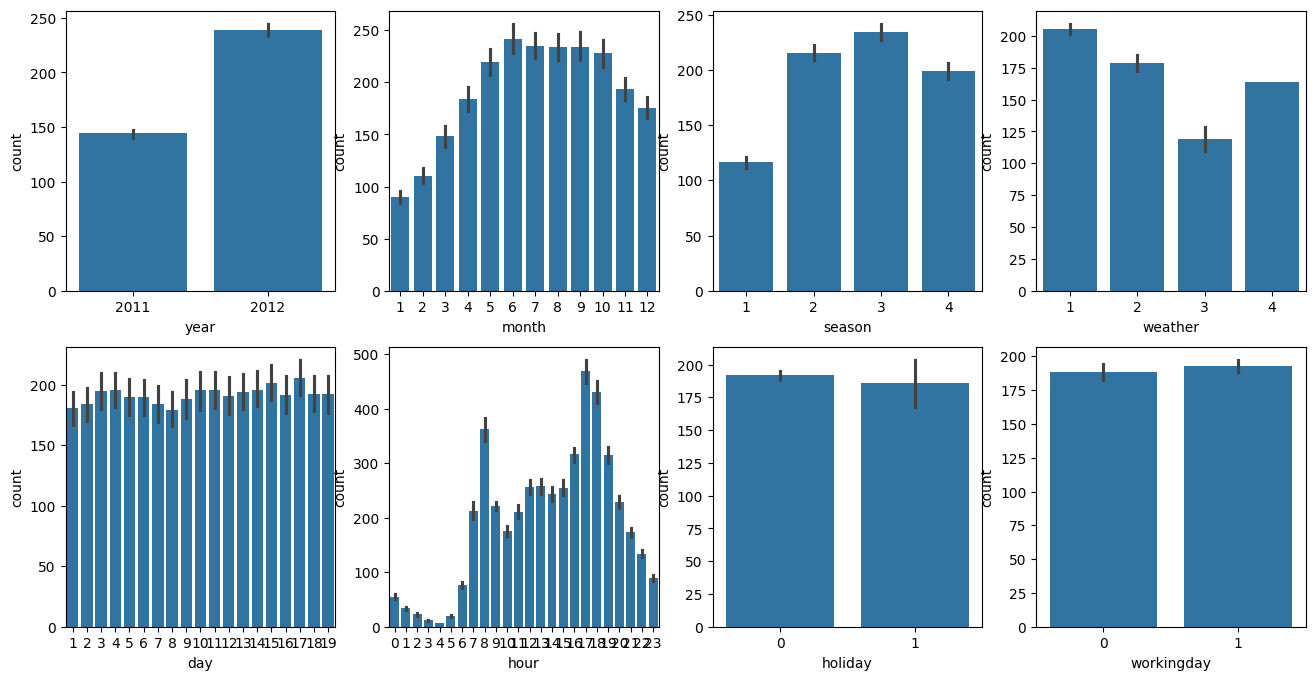

In [43]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday'] #범주형 변수들에 각각 count를 y축으로 barplot그리기
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화

# 범주형 변수 목록(cat_features)에 대해 하나씩 순회
for i, feature in enumerate(cat_features):
    # 현재 플롯을 그릴 행(row) 번호 계산 (4개씩 한 줄에 배치하려고)
    row = int(i / 4)
    # 현재 플롯을 그릴 열(column) 번호 계산
    col = i % 4
    # seaborn의 barplot을 사용하여 해당 feature별 count 합계 시각화
    # x축: feature (범주형 변수)
    # y축: 'count' 열의 값 (ex: 대여 횟수 등)
    # ax=axs[row][col]: 해당 subplot 위치에 그리기
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])


📌 각 지표 요약'

| 지표        | 계산 방법                     | 특징                              |
| --------- | ------------------------- | ------------------------------- |
| **MAE**   | 평균 절대 오차                  | 실제와 예측의 절대적 차이를 그대로 반영          |
| **RMSE**  | 평균 제곱 오차의 제곱근             | 큰 오차에 더 민감함 (제곱 때문에)            |
| **RMSLE** | log1p로 변환 후 오차의 제곱 평균의 루트 | 예측값과 실제값의 **비율적 차이**에 민감, 0에 강함 |


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ✅ RMSLE 계산 함수: log1p() 사용으로 log(0) 문제 방지
# log1p(x)의 경우 log(1+x)로 변환되므로 x값이 0이 되더라도 log(0)인 무한대가 되지 않고, log(1)인 0이 되므로 오버플로/ 언더플로 문제를 해결해 줌.
# log1p로 변환된 값도 다시 넘파이의 expm1() 함수로 쉽게 원래의 스케일로 복원될 수 있음

def rmsle(y, pred): #계산 전에 오차값 정의해주기
    log_y = np.log1p(y)              # log(1 + 실제값)
    log_pred = np.log1p(pred)        # log(1 + 예측값)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))  # 평균 후 제곱근
    return rmsle

# ✅ RMSE 계산 함수 (mean_squared_error의 제곱근)
def rmse(y, pred): #계산 전에 오차값 정의해주기
    return np.sqrt(mean_squared_error(y, pred))

# ✅ 세 가지 회귀 지표를 계산 및 출력하는 통합 평가 함수
def evaluate_regr(y, pred): #계산 전에 오차값 정의해주기
    rmsle_val = rmsle(y, pred)                       # RMSLE
    rmse_val = rmse(y, pred)                         # RMSE
    mae_val = mean_absolute_error(y, pred)           # MAE (평균 절대 오차)

    # 소수점 3자리까지 출력
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))


# 2. 로그 변환. 피쳐, 인코딩과 모델 학습/ 예측 평가

최귀 모델을 적용하기 전데 데이터 세트에 대해서 처리할 것들
* 결괏값이 정규 분표로 되어있는지
* 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처가 인코딩 되었는지

# 순서 1.

## 사이킷런의 LinearRegression 객체를 이용해 회귀 예측 하기

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV  # 데이터 분할 및 하이퍼파라미터 튜닝용 도구
from sklearn.linear_model import LinearRegression, Ridge, Lasso     # 선형 회귀 및 정규화 회귀 모델들 import

# 🎯 타겟 값(예측하려는 값): 자전거 대여 수(count)
y_target = bike_df['count']

# 🧾 피처 데이터: count를 제외한 나머지 변수들
X_features = bike_df.drop(['count'], axis=1, inplace=False)

# 🔀 훈련 데이터와 테스트 데이터로 분할 (train 70%, test 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.3, random_state=0)

# ✅ 선형 회귀 모델 생성 및 학습
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)  # 학습 수행

# ✅ 테스트셋에 대해 예측 수행
pred = lr_reg.predict(X_test)

# 📊 예측 결과를 기반으로 RMSE, RMSLE, MAE 지표 평가 (사용자 정의 evaluate_regr 함수 사용)
evaluate_regr(y_test, pred)


RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


RMSLE: 1.165, RMSE: 140.900, MAE: 105.924의 경우 실제 target값을 고려해보면 예측 오류로써는 비교적 큰 값임.

#실제 예측값과는 어느 정도 차이가 나는지 dataframe의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개 확인


In [46]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


** 상황 정리
간단한 전처리 이후 (칼럼 삭제 등)
1. 로그 변환 진행하고 사이킷 머신 러닝 함
- 원본과 차이가 큰 것을 확인하였음
- target 데이터 또한 시각화 하는 과정을 통해 정규 분포 형식인지 확인하는 과정을 거치는 중임
- 회귀 분석의 경우 데이터가 정규 분포의 형식을 가지고 있어야 함

<Axes: >

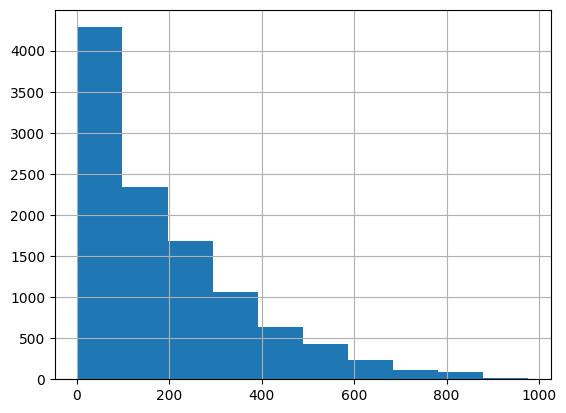

In [47]:
y_target.hist()

## 왜곡이 되어 있어서 정규 분포 형식으로 바꿈 -> 로그를 취해줌
- 왜곡이 아직도 존재하기는 하지만 이전 보다는 완화됨
- 이에 해당 데이터로 평가를 수행

📌 로그 변환했는데도 왜곡이 심할 경우 대안은?
✅ 루트 변환 (np.sqrt(y)): 로그보다 완만하게 분포를 조정함

예: count, views, 금액 같은 값

✅ Box-Cox 변환: 여러 변환(power transform)을 통합한 방법

python
Copy
Edit
from scipy.stats import boxcox
y_transformed, lambda_ = boxcox(y + 1)
✅ QuantileTransformer (비선형 스케일링)
Scikit-learn으로 극단적 비대칭 분포까지 정규화 가능



<Axes: >

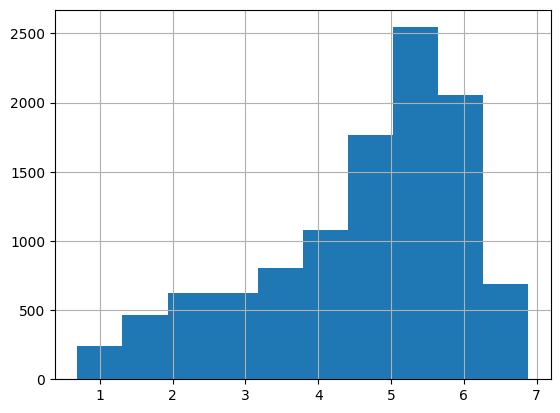

In [48]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [49]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


## RMSLE 오류는 줄었지만 RMSE는 늘어남 -> 개별 피처들의 인코딩을 적용하기

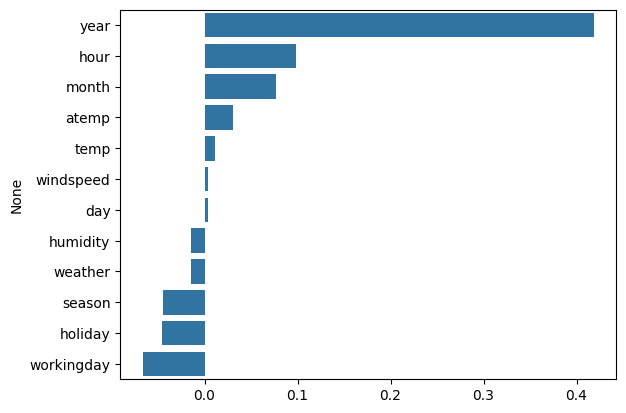

In [50]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

year, hour의 경우 피쳐값을 따로 살펴볼 필요가 잇음.
예를 들어, 이 경우에는 year가 2011, 2012로 분류 되어 있기에 피쳐의 영향도가 상대적으로 높게 나타나는 것임 - 그러나 큰 값으로 인식이 되어서는 안 됨.
year, hour, month 또한 마찬가지임.
# 사이킷런에서 회귀 계수가 category 형 인 경우 모두 숫자로 변환 하여야 하며 원-핫-인코딩을 통해 변환해햐 함

In [51]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding

# 없는 day까지 encoding
X_features['day'] = pd.Categorical(X_features['day'], categories=range(1, 31))


X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

# 원 핫 인코딩 작업을 다시 확인하는 과정

In [52]:
X_features_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
1,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
2,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
3,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
4,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10882,14.76,17.425,57,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10883,13.94,15.910,61,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10884,13.94,17.425,61,6.0032,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False


In [53]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환 (## 수행에 앞서서 (공통 함수)를 만들었음)
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# model 별로 평가 수행 - 모델 돌리기 전에 일단 평가 수행까지 짜 두었음 (공통 함수)
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True) #실제로 모델을 돌리는 과정

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


공통 함수를 사용하여 분석할 것

🧠 이렇게 구성하면 좋은 이유
* 이유	설명
* ✅ 재사용성	다양한 모델에 대해 반복해서 동일한 평가 가능
* ✅ 실험 관리	평가 지표가 일관되게 나와서 비교가 쉬움
* ✅ 유지보수	나중에 evaluate_regr()에 MAAPE 같은 지표 추가해도 전체 코드 수정 필요 없음
* ✅ 실험 설계와 실행 분리	함수만 먼저 만들어 놓고, 어떤 모델을 넣을지 전략적으로 결정 가능

# 원 - 핫 인코딩 이후 피쳐 늘어남, 회귀 계수 상위 20개 다시 검색하기
* 인코딩 잉후 피쳐들 영향력 달라지고 모델 성능 또하 향상되엇음.

<Axes: ylabel='None'>

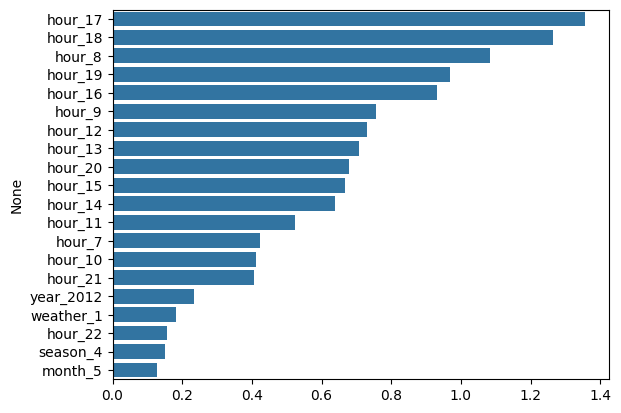

In [54]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

# 회계 트리 사용
앞서 작업한
* Target 값의 로그 변환된 값과
* 원-핫 인코딩된 피쳐 데이터 세트를 그대로 이용,
* 랜덤 포레스트, GBM, XGBoost, LightBGM을 순차적으로 성능 평가

In [55]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행에 앞서서 모델을 만들었음
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.338, MAE: 31.257
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.339, MAE: 32.740
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# 하이퍼 파라미터 튜닝 방법 가이드

우선 무슨 파라미터가 있는지 알아보자
검색을 해봅시다
공식문서나, 정리된 블로그를 찾아봅시다

아래는 그냥 구글에 lgbm 하이퍼 파라미터를 검색해봤을때 나온 블로그 하나를 예시로 넣어두었습니다

https://zzinnam.tistory.com/entry/lightgbm-%EC%A3%BC%EC%9A%94-%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-with-%ED%8C%8C%EC%9D%B4%EC%8D%AC

In [56]:
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV

# 각 모델에 대한 파라미터 그리드
param_grids = {
        'n_estimators': [500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [2, 4, 8, 16],
        'num_leaves': [31, 50, 70]
    }

model = LGBMRegressor()


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids,
        n_iter=10,
        scoring=rmsle_scorer,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
search.fit(X_train.values, y_train.values)
best_model = search.best_estimator_

print("Best Parameters:", search.best_params_)
get_model_predict(best_model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
Best Parameters: {'num_leaves': 31, 'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### LGBMRegressor ###
RMSLE: 0.315, RMSE: 46.495, MAE: 28.726


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 # 최적 파라미터로 학습된 best_model의 feature importance를 시각화

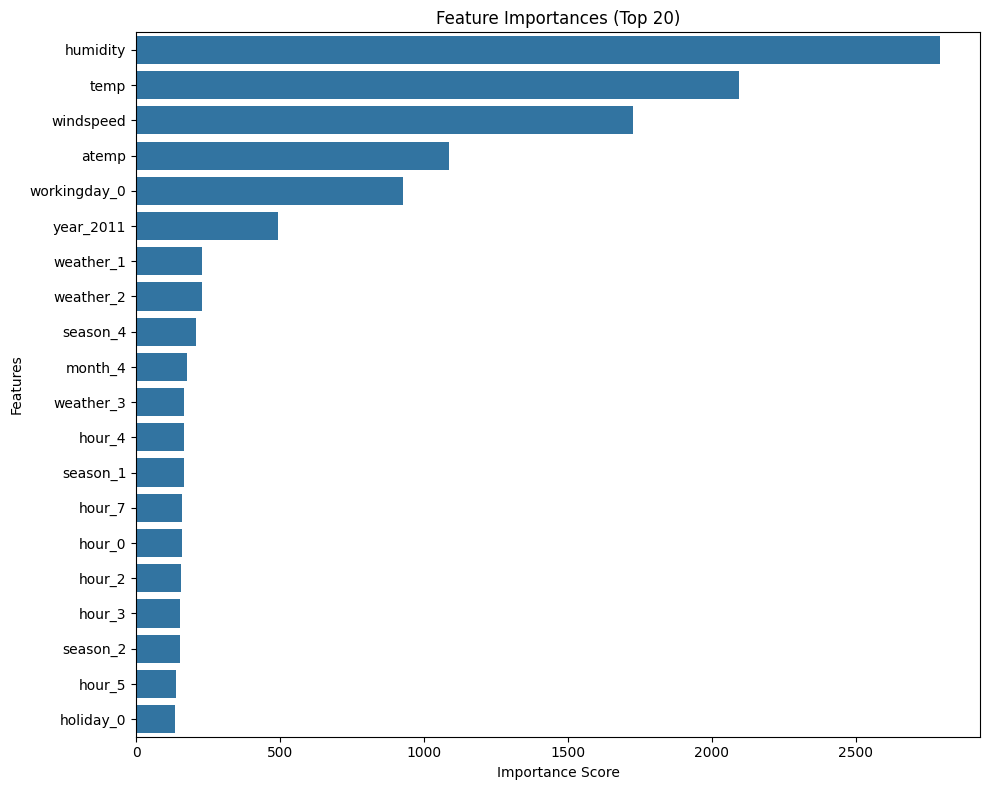

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 피처 중요도 추출
feature_imp = pd.Series(data=best_model.feature_importances_, index=X_train.columns)

# 중요도 상위 20개만 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_imp.sort_values(ascending=False)[:20],
            y=feature_imp.sort_values(ascending=False)[:20].index)
plt.title('Feature Importances (Top 20)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [58]:
# 하이퍼파라미터 튜닝 완료 → 최적 모델 저장
best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)

# ✅ [여기] cross_val_score 교차검증 평가 추가
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# RMSLE용 scorer 정의
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# 교차 검증 수행 (cv=3)
rmsle_scores = cross_val_score(
    best_model,
    X_train.values, y_train.values,
    scoring=rmsle_scorer,
    cv=3
)

# 결과 출력
print("📊 RMSLE (3-Fold CV):", -rmsle_scores)
print("📈 평균 RMSLE:", round(-rmsle_scores.mean(), 4))

# 이후에:

get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)



Best Parameters: {'num_leaves': 31, 'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 5080, number of used features: 72
[LightGBM] [Info] Start training from score 4.579565


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 5080, number of used features: 72
[LightGBM] [Info] Start training from score 4.587333


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 5080, number of used features: 72
[LightGBM] [Info] Start training from score 4.579233


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 RMSLE (3-Fold CV): [0.08713992 0.08836772 0.08398652]
📈 평균 RMSLE: 0.0865
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.332, RMSE: 51.381, MAE: 31.833


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### 평가 결과
### LGBMRegressor ###
Best Parameters: {'num_leaves': 31, 'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.1}

RMSLE: 0.315, RMSE: 46.495, MAE: 28.726

디폴트 값보다는 조금더 좋아졌다

In [59]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

Saving test.csv to test (1).csv


In [60]:
## test_data를 받아오기
test = pd.read_csv('./test.csv')

# train과 같은 전처리를 진행해보자

이것을 하다보면 엄청난 문제에 직면을 하게되는데  
그것은 바로 train data는 day가 1-19일까지   
그리고 test data는 day가 20-31일까지라서  
일반 onehot encoding을 하면 열개수가 달라진다는 사실이다...

일단 카테고리 범위를 지정해주고 더미를 만들어주자! 위에 train도 바꿔주는걸 잊지말자

In [61]:
# train과 같은 전처리를 진행해보자
test['datetime'] = test.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
test['year'] = test.datetime.apply(lambda x : x.year)
test['month'] = test.datetime.apply(lambda x : x.month)
test['day'] = test.datetime.apply(lambda x : x.day)
test['hour'] = test.datetime.apply(lambda x: x.hour)
test.head(3)

# 이미 테스트 데이터셋에는 casual, registered 가 빠져있음
drop_columns = ['datetime']
test.drop(drop_columns, axis=1,inplace=True)

# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
test['day'] = pd.Categorical(test['day'], categories=range(1, 31))
test_ohe = pd.get_dummies(test, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

#데이터에서 년, 월, 일, 시간 빼서 앞서서 돌렸던 모델대로 돌리는 것
#이후 sample에는 년/ 월/ 일/ 시간에 맞게 (행 순서를 바뀌지 않았으니) 해당 행을 끼워 넢음.
#이 떄 오류를 만들지 않으려면 파일을 미리 정렬 확인하거나 수정하는 전처리가 필요

In [62]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

Saving sampleSubmission.csv to sampleSubmission (1).csv


In [63]:
## sample_data를 받아오기
sample = pd.read_csv('./sampleSubmission.csv')

# count가 0으로 차있는 sample - sample 파일이 어떤지 확인해보기
sample

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [67]:

# 테스트 데이터셋을 예측
pred = best_model.predict(test_ohe)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["count"] = pred_exp

# csv로 저장하기
sample.to_csv("./submission.csv", index=False)

In [68]:
sample

,datetime,count
0,2011-01-20 00:00:00,10.976623
1,2011-01-20 01:00:00,4.077675
2,2011-01-20 02:00:00,2.431671
3,2011-01-20 03:00:00,2.986596
4,2011-01-20 04:00:00,1.544623
...,...,...
6488,2012-12-31 19:00:00,247.156714
6489,2012-12-31 20:00:00,167.401570
6490,2012-12-31 21:00:00,120.760211
6491,2012-12-31 22:00:00,95.814716


이유	설명
📄 제출 포맷 통일	캐글은 정해진 형식으로 제출해야만 자동 채점됨
🔁 훈련 vs 테스트 분리	모델 훈련과는 별도로, 오직 제출용 데이터에만 예측
🔒 점수 얻기 위함	캐글 leaderboard 점수를 받기 위한 실제 예측 결과물 생성

In [66]:
# 오른쪽에 생긴 submission.csv를 다운로드 받아서 캐글에 제출